# V2

## Importacion de librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json

In [2]:
from tqdm.auto import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [4]:
import warnings
warnings.filterwarnings("ignore")


## Carga del Dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

ruta = '/content/drive/MyDrive/Kapital Bank/Creditos Otorgados KB.xlsx'
excel = pd.read_excel(ruta, sheet_name=None)
print(excel.keys())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
dict_keys(['Créditos Otorgados', 'Ventas mensuales'])


In [6]:
df_ventas = excel['Ventas mensuales']

In [7]:
df_ventas['mes'] = pd.to_datetime(df_ventas['mes'])
df_ventas

,user,mes,monto
0,AAC13083,2014-06-01,4727.62
1,AAC13083,2014-07-01,98676.76
2,AAC13083,2014-08-01,110494.34
3,AAC13083,2014-09-01,162273.91
4,AAC13083,2014-10-01,240959.38
...,...,...,...
43202,ZPC17070,2022-10-01,9077065.82
43203,ZPC17070,2022-11-01,4186375.27
43204,ZPC17070,2022-12-01,3647776.69
43205,ZPC17070,2023-01-01,2421616.43


## Modelos

In [22]:

def smape(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    denom = np.where(denom == 0, 1e-9, denom)
    return np.mean(np.abs(y_true - y_pred) / denom) * 100

def wape(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    return np.sum(np.abs(y_true - y_pred)) / (np.sum(np.abs(y_true)) + 1e-9) * 100

def seasonal_naive_forecast(series, h=12):
    if len(series) >= 12:
        return series.iloc[-12:].values[:h]
    else:
        return np.repeat(series.iloc[-1], h)

def fit_airline(y):
    # SARIMA (0,1,1)(0,1,1,12)
    mod = SARIMAX(
        y, order=(0,1,1), seasonal_order=(0,1,1,12), trend='n',
        enforce_stationarity=False, enforce_invertibility=False,
        concentrate_scale=True
    )
    res = mod.fit(disp=False, maxiter=80, method='lbfgs')
    return res


In [23]:

H = 3                  # horizonte por bloque en backtest
gate_smape = 20.0      # si el naive tiene sMAPE <= 20, saltamos SARIMA

resultados = []
predicciones_12m = []

for cid, g in tqdm(df_ventas.groupby('user')):
    # Serie mensual limpia
    g = g.set_index('mes').asfreq('MS')
    y = g['monto'].astype(float).interpolate(limit_direction='both')

    # ---- backtesting sólo en últimos 12–18 meses
    min_train_idx = max(24, len(y) - 18)
    cortes = list(range(min_train_idx, len(y) - H + 1, H))

    # Si la serie es muy corta, usar Naive para forecast y continuar
    if len(cortes) == 0:
        ganador = 'naive'
        H12 = 12
        yhat = seasonal_naive_forecast(y, H12)
        fechas_fut = pd.date_range(start=y.index[-1] + pd.offsets.MonthBegin(1), periods=H12, freq='MS')
        predicciones_12m.append(pd.DataFrame({'user': cid, 'mes': fechas_fut, 'yhat': yhat, 'modelo_ganador': ganador}))
        resultados.append({'user': cid, 'sMAPE_naive': np.nan, 'sMAPE_sarima': np.nan, 'modelo_ganador': ganador})
        continue

    err = {'naive': [], 'sarima': []}

    for c in cortes:
        y_tr = y.iloc[:c]
        y_te = y.iloc[c:c+H]

        # Naive estacional
        yhat_naive = seasonal_naive_forecast(y_tr, H)
        e_naive = smape(y_te, yhat_naive)
        err['naive'].append(e_naive)

        # b) : si naive es suficientemente bueno, saltamos SARIMA
        if e_naive <= gate_smape:
            err['sarima'].append(np.inf)
            continue

        # c) SARIMA
        try:
            sar = fit_airline(y_tr)
            yhat_sar = sar.forecast(steps=H)
            e_sar = smape(y_te, yhat_sar)
        except Exception:
            e_sar = np.inf
        err['sarima'].append(e_sar)


    def safe_mean(a):
      a = np.asarray(a, dtype=float)
      a[~np.isfinite(a)] = np.nan
      return float(np.nanmean(a))


    # promedio por modelo
    smapes = {m: safe_mean(v) for m, v in err.items()}
    ganador = min(smapes, key=smapes.get)

    resultados.append({
        'user': cid,
        'sMAPE_naive': smapes['naive'],
        'sMAPE_sarima': smapes['sarima'],
        'modelo_ganador': ganador
    })

    #  Pronostico a 12 meses con el ganador
    H12 = 12
    if ganador == 'naive':
        yhat = seasonal_naive_forecast(y, H12)
    else:
        try:
            sar_full = fit_airline(y)
            yhat = sar_full.forecast(steps=H12).values
        except Exception:

            yhat = seasonal_naive_forecast(y, H12)

    fechas_fut = pd.date_range(start=y.index[-1] + pd.offsets.MonthBegin(1), periods=H12, freq='MS')
    predicciones_12m.append(pd.DataFrame({
        'user': cid,
        'mes': fechas_fut,
        'yhat': yhat,
        'modelo_ganador': ganador
    }))

resumen = pd.DataFrame(resultados)
forecast = pd.concat(predicciones_12m, ignore_index=True)

print("sMAPE promedio por modelo:")
print(resumen[['sMAPE_naive','sMAPE_sarima']].mean())

print("\n% de clientes por modelo ganador:")
print(resumen['modelo_ganador'].value_counts(normalize=True).mul(100).round(1))


  0%|          | 0/734 [00:00<?, ?it/s]

sMAPE promedio por modelo:
sMAPE_naive     81.541781
sMAPE_sarima    78.247572
dtype: float64

% de clientes por modelo ganador:
modelo_ganador
sarima    54.6
naive     45.4
Name: proportion, dtype: float64


In [24]:
df_ventas

,user,mes,monto
0,AAC13083,2014-06-01,4727.62
1,AAC13083,2014-07-01,98676.76
2,AAC13083,2014-08-01,110494.34
3,AAC13083,2014-09-01,162273.91
4,AAC13083,2014-10-01,240959.38
...,...,...,...
43202,ZPC17070,2022-10-01,9077065.82
43203,ZPC17070,2022-11-01,4186375.27
43204,ZPC17070,2022-12-01,3647776.69
43205,ZPC17070,2023-01-01,2421616.43


## Graficos

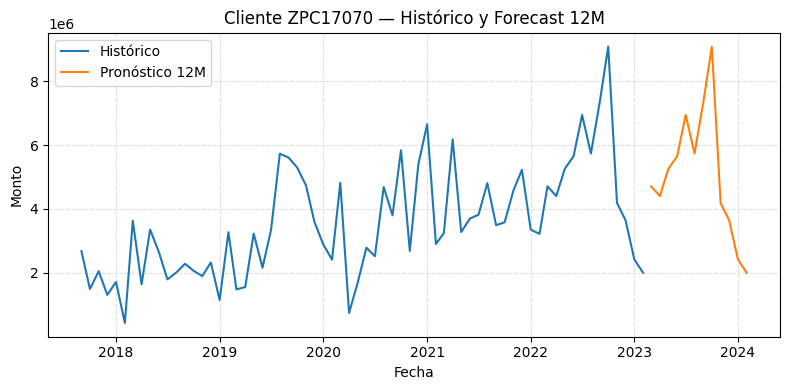

In [21]:

# Se toma cualquier user
cid_demo = df_ventas['user'].iloc[43202]
hist_cli = df_ventas[df_ventas['user'] == cid_demo].set_index('mes')['monto'].asfreq('MS')
fut_cli = forecast[forecast['user'] == cid_demo].set_index('mes')['yhat']

plt.figure(figsize=(8,4))
plt.plot(hist_cli.index, hist_cli.values, label='Histórico')
plt.plot(fut_cli.index, fut_cli.values, label='Pronóstico 12M')
plt.title(f'Cliente {cid_demo} — Histórico y Forecast 12M')
plt.xlabel('Fecha'); plt.ylabel('Monto')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


# No ejecutar

## Importacion de Librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json

In [2]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report, brier_score_loss,
    mean_absolute_error, mean_squared_error
)
from sklearn.metrics import  precision_score, recall_score, f1_score, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRegressor

!pip -q install pmdarima xgboost numpy --upgrade
# from pmdarima import auto_arima

from statsmodels.tsa.arima.model import ARIMA

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 56.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.4 which is incompatible.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.4 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.3.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>

In [3]:
# !pip install --upgrade pip
# !pip install pmdarima --quiet


In [4]:
# from pmdarima import auto_arima

## Carga del Dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from google.colab import drive
drive.mount('/content/drive')

ruta = '/content/drive/MyDrive/Kapital Bank/Creditos Otorgados KB.xlsx'
excel = pd.read_excel(ruta, sheet_name=None)
print(excel.keys())

dict_keys(['Créditos Otorgados', 'Ventas mensuales'])


In [7]:
df_ventas = excel['Ventas mensuales']

In [8]:
df_ventas

,user,mes,monto
0,AAC13083,2014-06-01,4727.62
1,AAC13083,2014-07-01,98676.76
2,AAC13083,2014-08-01,110494.34
3,AAC13083,2014-09-01,162273.91
4,AAC13083,2014-10-01,240959.38
...,...,...,...
43202,ZPC17070,2022-10-01,9077065.82
43203,ZPC17070,2022-11-01,4186375.27
43204,ZPC17070,2022-12-01,3647776.69
43205,ZPC17070,2023-01-01,2421616.43


In [9]:
df_ventas['mes'] = pd.to_datetime(df_ventas['mes'])
df_ventas

,user,mes,monto
0,AAC13083,2014-06-01,4727.62
1,AAC13083,2014-07-01,98676.76
2,AAC13083,2014-08-01,110494.34
3,AAC13083,2014-09-01,162273.91
4,AAC13083,2014-10-01,240959.38
...,...,...,...
43202,ZPC17070,2022-10-01,9077065.82
43203,ZPC17070,2022-11-01,4186375.27
43204,ZPC17070,2022-12-01,3647776.69
43205,ZPC17070,2023-01-01,2421616.43


In [10]:
hist = df_ventas.groupby('user').size()
valid_ids = hist[hist >= 24].index
df_ventas = df_ventas[df_ventas['user'].isin(valid_ids)].copy()
df_ventas.sample(10)

,user,mes,monto
7760,CHR90121,2014-01-01,1.845024e+06
17322,GCO10122,2022-02-01,3.120187e+06
34183,RULS7901,2015-07-01,5.786142e+05
8253,CJZ13053,2016-02-01,5.491029e+05
31353,POPF5906,2021-01-01,9.870395e+04
18349,GGH19120,2022-09-01,8.553674e+05
14451,ENE10111,2018-05-01,1.095630e+06
28663,NIM18060,2022-09-01,2.861407e+06
6473,CCO18052,2020-10-01,2.962855e+05
22127,IBS05052,2021-11-01,1.195707e+06


In [11]:
def smape(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    denom = np.where(denom == 0, 1e-9, denom)
    return np.mean(np.abs(y_true - y_pred) / denom) * 100

def wape(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    return np.sum(np.abs(y_true - y_pred)) / (np.sum(np.abs(y_true)) + 1e-9) * 100

def seasonal_naive_forecast(series, h=12):
    # mismo mes del año anterior; si no hay 12 meses, repite último
    if len(series) >= 12:
        # toma los últimos 12 y corta h
        return series.iloc[-12:].values[:h]
    else:
        return np.repeat(series.iloc[-1], h)


In [12]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

def fit_auto_sarima(y, m=12,
                    p=(0,1,2), d=(0,1), q=(0,1,2),
                    P=(0,1),  D=(0,1), Q=(0,1)):
    """
    Devuelve el mejor modelo SARIMAX por AIC.
    y: Serie pandas con índice datetime de frecuencia mensual (MS).
    """
    best_aic = np.inf
    best_model = None
    for pi, di, qi in itertools.product(p, d, q):
        for Pi, Di, Qi in itertools.product(P, D, Q):
            order = (pi, di, qi)
            seas = (Pi, Di, Qi, m)
            try:
                mod = SARIMAX(y, order=order, seasonal_order=seas,
                              enforce_stationarity=False, enforce_invertibility=False)
                res = mod.fit(disp=False)
                if res.aic < best_aic:
                    best_aic = res.aic
                    best_model = res
            except Exception:
                continue
    return best_model  # res entrenado


In [13]:
from statsmodels.tsa.arima.model import ARIMA

def fit_auto_arima_simple(y, p=(0,1,2), d=(0,1), q=(0,1,2)):
    best_aic = np.inf
    best_model = None
    for pi, di, qi in itertools.product(p, d, q):
        try:
            res = ARIMA(y, order=(pi,di,qi)).fit()
            if res.aic < best_aic:
                best_aic = res.aic
                best_model = res
        except Exception:
            continue
    return best_model


In [ ]:
from tqdm.auto import tqdm

H = 3          # horizonte por bloque de validación
min_train = 18 # meses de arranque antes del primer corte

resultados = []
predicciones_12m = []

for cid, g in tqdm(df_ventas.groupby('user')):
    # Serie mensual
    g = g.set_index('mes').asfreq('MS')
    y = g['monto'].astype(float).interpolate(limit_direction='both')

    # cortes sobre últimos meses
    cortes = list(range(min_train, len(y) - H + 1, H))
    err = {'naive': [], 'sarima': []}  # cambia a 'arima' si usas ARIMA simple

    # ---- backtesting
    for c in cortes:
        y_tr = y.iloc[:c]
        y_te = y.iloc[c:c+H]

        # Naive estacional
        yhat_naive = seasonal_naive_forecast(y_tr, H)
        err['naive'].append(smape(y_te, yhat_naive))

        # SARIMA (si prefieres ARIMA no estacional, cambia por fit_auto_arima_simple)
        try:
            sar = fit_auto_sarima(y_tr, m=12)
            yhat_sar = sar.forecast(steps=H)
            err['sarima'].append(smape(y_te, yhat_sar))
        except Exception:
            err['sarima'].append(np.inf)

    smapes = {m: float(np.mean(v)) for m, v in err.items()}
    ganador = min(smapes, key=smapes.get)

    resultados.append({
        'user': cid,
        'sMAPE_naive': smapes['naive'],
        'sMAPE_sarima': smapes['sarima'],
        'modelo_ganador': ganador
    })

    # ---- pronóstico a 12 meses con el ganador
    H12 = 12
    if ganador == 'naive':
        yhat = seasonal_naive_forecast(y, H12)
    else:
        sar = fit_auto_sarima(y, m=12)
        yhat = sar.forecast(steps=H12).values

    fechas_fut = pd.date_range(start=y.index[-1] + pd.offsets.MonthBegin(1), periods=H12, freq='MS')
    predicciones_12m.append(pd.DataFrame({
        'user': cid,
        'mes': fechas_fut,
        'yhat': yhat,
        'modelo_ganador': ganador
    }))

resumen = pd.DataFrame(resultados)
forecast = pd.concat(predicciones_12m, ignore_index=True)


  0%|          | 0/734 [00:00<?, ?it/s]

Se truncaron las últimas líneas 5000 del resultado de transmisión.
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/sta

In [ ]:
print("sMAPE promedio por modelo:")
print(resumen[['sMAPE_naive','sMAPE_sarima']].mean())   # agrega 'sMAPE_arima' si usas ARIMA simple

print("\n% de clientes por modelo ganador:")
print(resumen['modelo_ganador'].value_counts(normalize=True).mul(100).round(1))

# Entregables
# resumen.to_csv('/content/resumen_modelos_backtest.csv', index=False)
# forecast.to_csv('/content/forecast_12m_por_cliente.csv', index=False)


In [ ]:
# 1) Reemplaza SARIMA por ARIMA simple:
ar = fit_auto_arima_simple(y_tr)           # en backtest
yhat_ar = ar.forecast(steps=H)
err['arima'].append(smape(y_te, yhat_ar))

# 2) En el ganador/forecast 12m:
ar = fit_auto_arima_simple(y)
yhat = ar.forecast(steps=H12).values
